<a href="https://colab.research.google.com/github/saksham1211/Marketingai_Internship/blob/master/%5BCNN%5DImage_Classification_based_on_Logos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [50]:
data_dir = '/content/drive/My Drive/data/train'

def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([#transforms.RandomRotation(30),  
    #                                    transforms.RandomResizedCrop(224),  
    #                                    transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.ToTensor()
                                      #  transforms.Normalize([0.485, 0.456, 0.406], 
                                      #                 [0.229, 0.224, 0.225]) 
                                       ])

    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor()
                                      # transforms.Normalize([0.485, 0.456, 0.406],
                                      #                      [0.229, 0.224, 0.225])
                                      ])

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['AMD', 'Acer', 'Apple', 'Asus', 'BEATS', 'BLACKBERRY']


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [52]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
epochs = 10
steps = 0
running_loss = 0
print_every = 1
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            torch.save(model, 'logo_detection.pth')

Epoch 1/10.. Train loss: 2.272.. Test loss: 2.073.. Test accuracy: 0.259
Epoch 1/10.. Train loss: 1.752.. Test loss: 2.993.. Test accuracy: 0.103
Epoch 1/10.. Train loss: 4.687.. Test loss: 3.000.. Test accuracy: 0.293
Epoch 1/10.. Train loss: 5.821.. Test loss: 2.494.. Test accuracy: 0.293
Epoch 2/10.. Train loss: 3.113.. Test loss: 2.728.. Test accuracy: 0.345
Epoch 2/10.. Train loss: 3.059.. Test loss: 4.207.. Test accuracy: 0.207
Epoch 2/10.. Train loss: 3.532.. Test loss: 3.809.. Test accuracy: 0.224
Epoch 2/10.. Train loss: 3.749.. Test loss: 2.624.. Test accuracy: 0.293
Epoch 3/10.. Train loss: 2.084.. Test loss: 1.766.. Test accuracy: 0.379
Epoch 3/10.. Train loss: 1.032.. Test loss: 1.570.. Test accuracy: 0.345
Epoch 3/10.. Train loss: 1.124.. Test loss: 1.575.. Test accuracy: 0.362
Epoch 3/10.. Train loss: 1.275.. Test loss: 1.313.. Test accuracy: 0.586
Epoch 4/10.. Train loss: 1.022.. Test loss: 1.289.. Test accuracy: 0.621
Epoch 4/10.. Train loss: 0.966.. Test loss: 1.360..

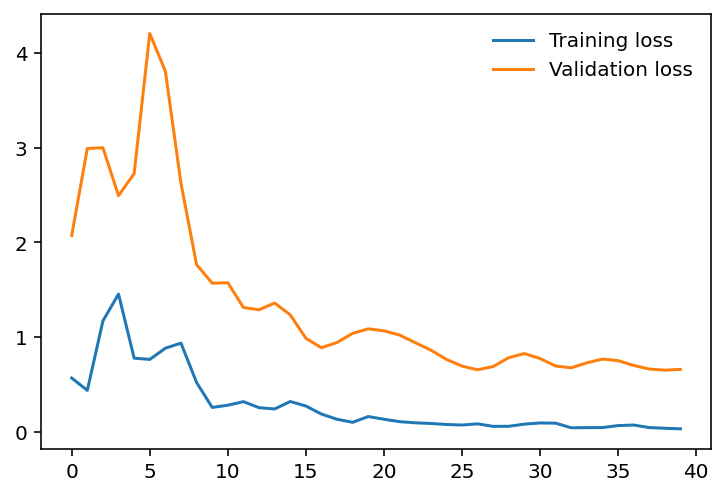

In [54]:
 plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [0]:
data_dir = '/content/drive/My Drive/data/train'

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor()
                                      # transforms.Normalize([0.485, 0.456, 0.406],
                                      #                    [0.229, 0.224, 0.225])
                                     ])

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('logo_detection.pth')
model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [0]:
from PIL import Image
from torch.autograd import Variable

In [0]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

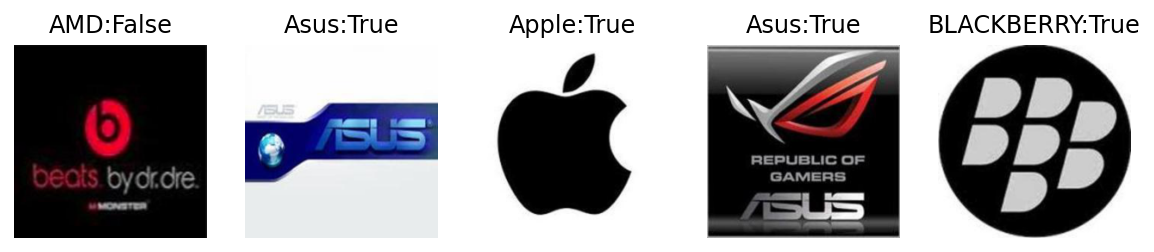

In [72]:
to_pil = transforms.ToPILImage()
data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes

images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

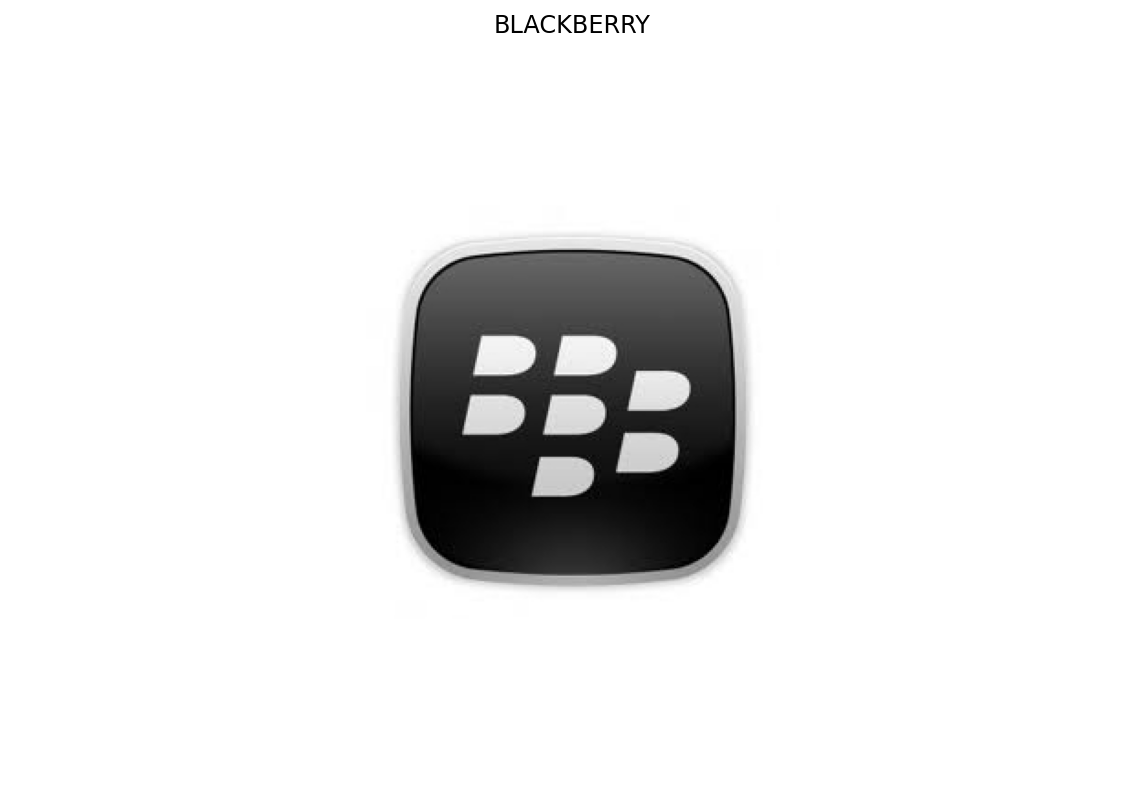

In [78]:
from matplotlib import image
to_pil = transforms.ToPILImage()
data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes
fig=plt.figure(figsize=(10,10))
image = to_pil(image.imread('/content/bb.jpeg'))
index = predict_image(image)
sub = fig.add_subplot(1, 1, 1)
sub.set_title(str(classes[index]))
plt.axis('off')
plt.imshow(image)
plt.show()
